<a href="https://colab.research.google.com/github/d61h6k4/EML/blob/main/Calibration_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

from collections import Counter
from matplotlib import pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import ShuffleSplit

import torch

In [ ]:
X, Y = load_wine(return_X_y=True)
train_val_idx, test_idx = next(ShuffleSplit(n_splits=1, test_size=0.2).split(X, Y))
train_idx, val_idx = next(ShuffleSplit(n_splits=1, test_size=0.2).split(X[train_val_idx], Y[train_val_idx]))
X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

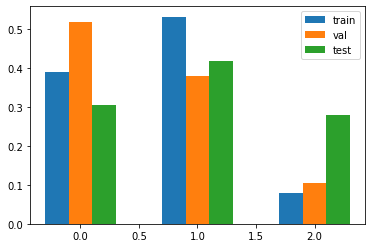

In [ ]:
fig, ax = plt.subplots()

train_counter = Counter(Y_train)
val_counter = Counter(Y_val)
test_counter = Counter(Y_test)

ax.bar([x - 0.2 for x in train_counter.keys()], [x / sum(train_counter.values())  for x in train_counter.values()], align="center", width=0.2, label="train")
ax.bar(val_counter.keys(), [x / sum(val_counter.values())  for x in val_counter.values()], align="center", width=0.2, label="val")
ax.bar([x + 0.1 for x in test_counter.keys()], [x / sum(test_counter.values())  for x in test_counter.values()], align="edge", width=0.2, label="test")
ax.legend()

fig.show()

## Model

In [ ]:
input_dim = 13
hidden_dim = 3
output_dim = 3

W = torch.empty((input_dim, output_dim), requires_grad=True)
torch.nn.init.xavier_normal_(W)
b = torch.empty((output_dim,), requires_grad=True)

### Training

In [ ]:
x_batch = torch.from_numpy(X_train).float()
y_batch = torch.from_numpy(Y_train)

In [ ]:
learning_rate = 4e-5
loss = torch.nn.CrossEntropyLoss()

In [ ]:
for ix in range(50000):

    y_raw = x_batch @ W + b

    output = loss(y_raw, y_batch)
    output.backward()
    W.data += -learning_rate * W.grad
    b.data += -learning_rate * b.grad

    W.grad = None
    b.grad = None

    if ix % 5000 == 0:
        print(output.item())

225.2593231201172
0.5816102027893066
0.3684985339641571
0.3531574010848999
0.3413535952568054
0.33036768436431885
0.3200596570968628
0.310367226600647
0.3012453317642212
0.2926490306854248


### Calibration

In [ ]:
pred_val = torch.nn.functional.softmax(torch.from_numpy(X_val).float() @ W + b, dim=1)
torch.argmax(pred_val, dim=1)

tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 0])

In [ ]:
qhat = torch.quantile(pred_val[torch.arange(pred_val.size(dim=0)), Y_val], 0.1, interpolation="lower")
torch.where(pred_val > qhat)

(tensor([ 0,  1,  2,  3,  3,  4,  5,  6,  6,  7,  8,  9, 10, 11, 12, 13, 14, 14,
         15, 16, 16, 17, 17, 18, 19, 20, 21, 22, 22, 23, 24, 24, 25, 26, 26, 27,
         28]),
 tensor([1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1,
         0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 0]))

In [ ]:
Y_val

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 2, 1, 0, 1, 0])

## Inference

In [ ]:
pred_test = torch.nn.functional.softmax(torch.from_numpy(X_test).float() @ W + b, dim=1)

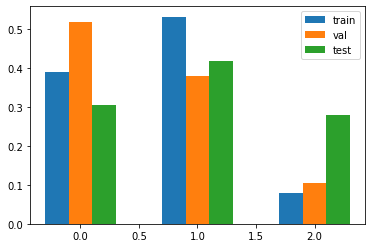

In [ ]:
fig, ax = plt.subplots()

train_counter = Counter(Y_train)
val_counter = Counter(Y_val)
test_counter = Counter(Y_test)

ax.bar([x - 0.2 for x in train_counter.keys()], [x / sum(train_counter.values())  for x in train_counter.values()], align="center", width=0.2, label="train")
ax.bar(val_counter.keys(), [x / sum(val_counter.values())  for x in val_counter.values()], align="center", width=0.2, label="val")
ax.bar([x + 0.1 for x in test_counter.keys()], [x / sum(test_counter.values())  for x in test_counter.values()], align="edge", width=0.2, label="test")
ax.legend()

fig.show()

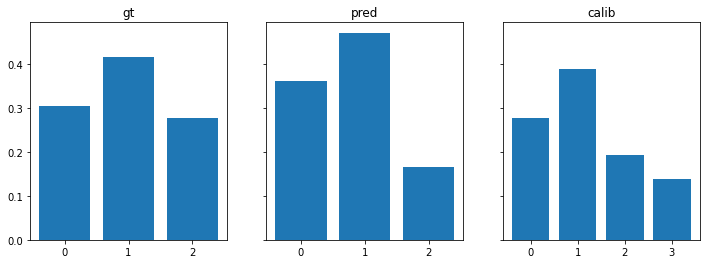

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=True)

for ax, label, y in zip(axs, ("gt", "pred", "calib"), (Y_test, torch.argmax(pred_test, dim=1).numpy(), torch.where((pred_test > qhat)[torch.arange(pred_test.size(dim=0)), Y_test], torch.from_numpy(Y_test), torch.tensor([3])).numpy())):
    c = Counter(y)
    ax.set_title(label)
    ax.bar(c.keys(), [x / sum(c.values()) for x in c.values()])
fig.show()